# Getting Started

In [57]:
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib
from PIL import Image

import tensorflow as tf

In [38]:
train_dir = pathlib.Path('./dataset/fruits-360_dataset/fruits-360/Training')
test_dir = pathlib.Path('./dataset/fruits-360_dataset/fruits-360/Test')

In [40]:
train_image_count = len(list(train_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))
print(f'{train_image_count} images for training')
print(f'{test_image_count} images for testing')

67692 images for training
22688 images for testing


# Visualization

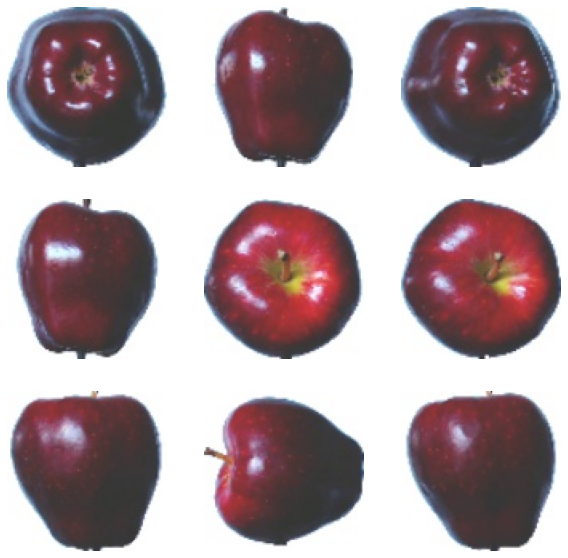

In [41]:
fruits = list(train_dir.glob('Apple Red Delicious/*.jpg'))

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [42]:
batch_size = 32
img_height = 100
img_width = 100

In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [46]:
class_names = train_ds.class_names
num_classes = len(class_names)

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


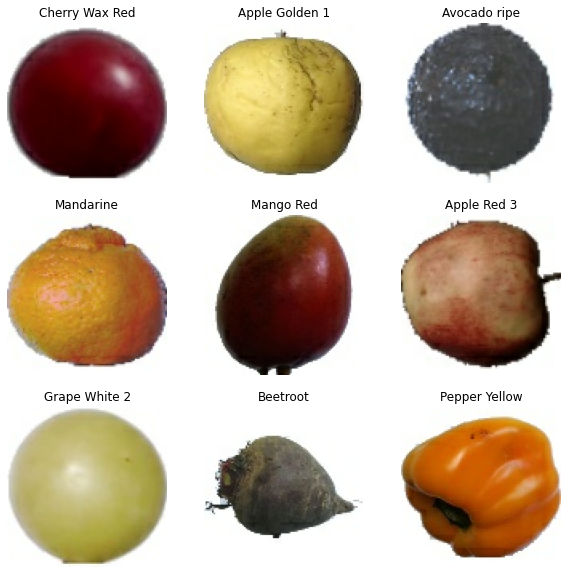

In [45]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [47]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 100, 100, 3)
(32,)


# Preprocessing/Setting Up Base Model

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [49]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [50]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [51]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

In [52]:
base_model.trainable = False

In [53]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

# Building the Model

In [54]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [56]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 100, 100, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

# Training the Model

In [65]:
checkpoint_path = 'checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
model.evaluate(val_ds)

424/424 [==============================] - 147s 346ms/step - loss: 0.0645 - accuracy: 0.9939


[0.06453273445367813, 0.9938691258430481]

In [66]:
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
1693/1693 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9902
Epoch 1: saving model to checkpoints/cp.ckpt
1693/1693 [==============================] - 839s 495ms/step - loss: 0.0635 - accuracy: 0.9902 - val_loss: 0.0417 - val_accuracy: 0.9969
Epoch 2/10
1693/1693 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9935
Epoch 2: saving model to checkpoints/cp.ckpt
1693/1693 [==============================] - 834s 493ms/step - loss: 0.0430 - accuracy: 0.9935 - val_loss: 0.0271 - val_accuracy: 0.9985
Epoch 3/10
1693/1693 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9955
Epoch 3: saving model to checkpoints/cp.ckpt
1693/1693 [==============================] - 813s 480ms/step - loss: 0.0305 - accuracy: 0.9955 - val_loss: 0.0213 - val_accuracy: 0.9987
Epoch 4/10
1693/1693 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9966
Epoch 4: saving model to checkpoints/cp.ckpt
1693/1693 [======

INFO:tensorflow:Assets written to: saved_keras/assets


INFO:tensorflow:Assets written to: saved_keras/assets


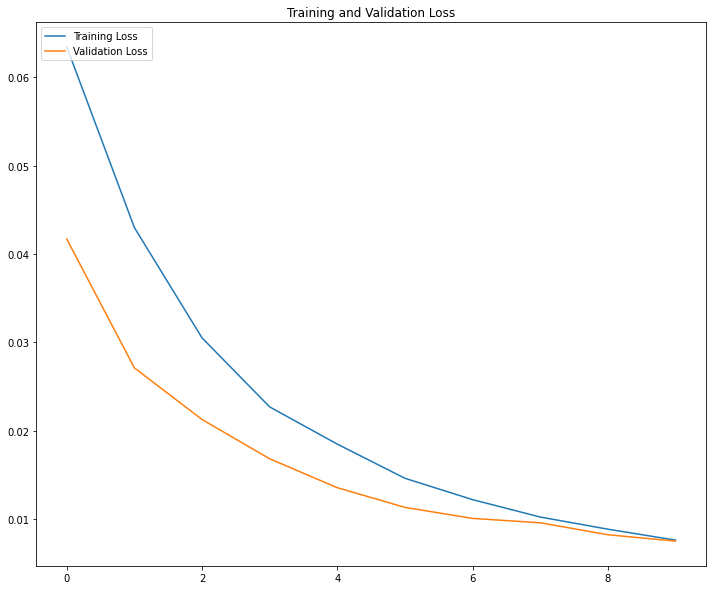

In [67]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

model.save(filepath='saved_keras')
model.save(filepath='saved.h5')

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
np.argmin(val_loss)

9